In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import sys
import os

# circumvent src import errors
sys.path.append(os.path.abspath('..'))

from src.data import data
from src.features import preprocessing
from src.utilities import utilities
from pprint import pprint

##### Loading the raw dataset

In [2]:
relevant_cols = ['asin', 'overall', 'verified', 'reviewerID', 'reviewText']
prod_raw = pd.read_csv("../data/raw/Kindle_Store_5.csv")
# need to drop all null values in reviews
prod_raw.dropna(axis=0, subset=['reviewText'], inplace=True)

# summary statistics
utilities.summary_statistics(prod_raw)
prod_raw.head()

/Users/jensen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The dataframe consists of 2222573 rows and 12 columns
The number of unique reviewerID: 139815
The number of unique reviewText: 2114477
The number of unique asin: 98824


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,True,"07 3, 2014",A2LSKD2H9U8N0J,B000FA5KK0,{'Format:': ' Kindle Edition'},sandra sue marsolek,"pretty good story, a little exaggerated, but I...",pretty good story,1404345600,NaN,NaN
1,5.0,True,"05 26, 2014",A2QP13XTJND1QS,B000FA5KK0,{'Format:': ' Kindle Edition'},Tpl,"If you've read other max brand westerns, you k...",A very good book,1401062400,NaN,NaN
2,5.0,True,"09 16, 2016",A8WQ7MAG3HFOZ,B000FA5KK0,{'Format:': ' Kindle Edition'},Alverne F. Anderson,"Love Max, always a fun twist",Five Stars,1473984000,NaN,NaN
3,5.0,True,"03 3, 2016",A1E0MODSRYP7O,B000FA5KK0,{'Format:': ' Kindle Edition'},Jeff,"As usual for him, a good book",a good,1456963200,NaN,NaN
4,5.0,True,"09 10, 2015",AYUTCGVSM1H7T,B000FA5KK0,{'Format:': ' Kindle Edition'},DEHS - EddyRapcon,MB is one of the original western writers and ...,A Western,1441843200,2,NaN


##### Loading the merged dataset 

In [3]:
relevant_cols = ['title', 'description', 'details', 'asin', 'overall', 'verified', 'reviewerID', 'reviewText']
prod_merged = pd.read_csv("../data/interim/Kindle_Store_5_merged.csv", usecols=relevant_cols)

# summary statistics
utilities.summary_statistics(prod_merged)
prod_merged.head()

The dataframe consists of 1846590 rows and 8 columns
The number of unique reviewerID: 130008
The number of unique reviewText: 1843681
The number of unique asin: 98059


,description,title,details,asin,overall,verified,reviewerID,reviewText
0,[],Brother One Cell,"{'File Size:': '766 KB', 'Print Length:': '368...",B0012DHDVS,5.0,False,A230ZS8F6I0AGM,"I've learned so much from Cullen, for example:..."
1,[],God in the White House,"{'File Size:': '605 KB', 'Print Length:': '260...",B0012GTZCK,3.0,True,A2DMROV9MIMSDU,Not what I was expecting. I was looking for a ...
2,[],God in the White House,"{'File Size:': '605 KB', 'Print Length:': '260...",B0012GTZCK,5.0,True,ARZXHYT2EH1V0,This short book reveals realities vital to the...
3,[],Vingt Mille Lieues sous les mers (French Editi...,"{'File Size:': '1097 KB', 'Print Length:': '60...",B0012LHGJ4,5.0,True,AYKIGSPZ8TLR7,IT WAS DONE AS A FILM IN THE 1950-60s. VERY P...
4,[],Wood-Carving Design and Workmanship - Kindle e...,"{'File Size:': '6851 KB', 'Print Length:': '31...",B0012RMVH0,5.0,True,AQR816QPFU5JE,Excellent book. This is something I have wante...


##### Creating `Verified` and `Unverified` Split

In [4]:
prod_verified, prod_unverified = data.make_dataset(prod_merged)

# summary statistics
print("Statistics for `Verified` reviews:")
utilities.summary_statistics(prod_verified)
print("\n")
print("Statistics for `Unverified` reviews:")
utilities.summary_statistics(prod_unverified)

Statistics for `Verified` reviews:
The dataframe consists of 1121827 rows and 8 columns
The number of unique reviewerID: 119757
The number of unique reviewText: 1119927
The number of unique asin: 93519


Statistics for `Unverified` reviews:
The dataframe consists of 724763 rows and 8 columns
The number of unique reviewerID: 80255
The number of unique reviewText: 723943
The number of unique asin: 82166


##### Loading product metadata

In [6]:
prod_metadata = pd.read_csv("../data/interim/meta_Kindle_Store_5.csv", usecols=['title', 'description', 'asin', 'price'])

# summary statistics
utilities.summary_statistics(prod_metadata, cols=['asin'])
prod_metadata.head()

The dataframe consists of 491670 rows and 4 columns
The number of unique asin: 491670


,description,title,price,asin
0,[],NaN,NaN,B000FA5KKA
1,[],NaN,NaN,B000FA5M3K
2,[],NaN,NaN,B000FA5KJQ
3,[],NaN,NaN,B000FA5NSO
4,[],NaN,NaN,B000FA5KX2


### 1. Exploratory Data Analysis

##### What is the global average rating, per product, per reviewer?

In [7]:
reviews_df = [prod_raw, prod_merged, prod_verified, prod_unverified]

In [8]:
for df in reviews_df:
    utilities.reviews_count(df)

Global average ratings: 4.394655653605079
For product reviews:
Minimum reviews for product: 1, Maximum reviews for products: 2217
Average reviews per products: 22.490214927547964
The interquartile range:
0.25     7.0
0.50    12.0
0.75    24.0
Name: reviewText, dtype: float64

For user reviews:
Minimum reviews for users: 1, Maximum reviews for users: 1377
Average reviews per users: 15.89652755426814
The interquartile range:
0.25     6.0
0.50     8.0
0.75    14.0
Name: reviewText, dtype: float64

Global average ratings: 4.390552315348832
For product reviews:
Minimum reviews for product: 1, Maximum reviews for products: 1752
Average reviews per products: 18.831417819883946
The interquartile range:
0.25     6.0
0.50    10.0
0.75    20.0
Name: reviewText, dtype: float64

For user reviews:
Minimum reviews for users: 1, Maximum reviews for users: 1364
Average reviews per users: 14.2036643898837
The interquartile range:
0.25     5.0
0.50     7.0
0.75    13.0
Name: reviewText, dtype: float64

G

##### Computing average rating per product

In [9]:
prod_ratings = []

for df in reviews_df:
    ratings = preprocessing.compute_mean_ratings(df, 'reviewText', 'overall')
    prod_ratings.append(ratings)
    
print(len(prod_ratings))

4


In [10]:
prod_ratings_raw, prod_ratings_merged, prod_ratings_verified, prod_ratings_unverified = prod_ratings

In [11]:
for rating in prod_ratings:
    print("==========")
    print(f"Average of average ratings: {rating['rating_average'].mean()}")
    print(rating.sort_values(['rating_average'], ascending=False).head(10))
    print("\n")

Average of average ratings: 4.370028337328869
             asin  rating_counts  rating_average
32480  B00GO942QO              8             5.0
12021  B0090R7BRO              8             5.0
27838  B00ER8ECL4             14             5.0
42502  B00JYFN72A             13             5.0
55128  B00OQPOOZM              6             5.0
27854  B00EREDDTA              5             5.0
74355  B011CX8DO8             18             5.0
21515  B00CCSUJXG              6             5.0
88421  B01AVT7188              5             5.0
88422  B01AVTFXP6              5             5.0


Average of average ratings: 4.360667974967413
             asin  rating_counts  rating_average
0      B0012DHDVS              1             5.0
58838  B00R0D4FD8             11             5.0
59091  B00R4ZI7X6              4             5.0
59081  B00R4UVA76              6             5.0
59049  B00R3TEPGQ              4             5.0
9475   B007IZWQUM              6             5.0
59036  B00R3KKTKQ       

Based on the output, you observed that for all the Top 10 product average ratings obtained across all 4 different variation of the dataset, all 4 dataframe has shown that the top 10 products (with 5.0 ratings) are all products with little reviews (< 50).

Consider this, if we were to recommend such products to others soley because the fact that they obtained an average rating of 5.0, we may be "*inaccurately*" recommending such items as they might just be relative new items that has not been thorough ordered and used by the wider consumer base on the platform.

Hence, we will need devised a rating that is more concrete and can factor in a threshold amount of ratings required for a product to get listed on the `product ranking`. This provides a more balance look to the ratings of a product as we now consider the global settings.

In [12]:
def compute_weighted_ratings(df, count_col, avg_rating_col, threshold=.75):
    """Computes weighted ratings based on number of ratings and average rating.

        Args:
            df [pd.DataFrame]: DataFrame consisting both rating counts and average rating.
            count_col [str]: Column name for number of ratings.
            avg_rating_col [str]: Column name for average rating.
            threshold [float]: Threshold for minimum of ratings/reviews to qualify for ranking.
        Returns:
            df [pd.DataFrame]: DataFrame with newly computed weighted ratings
    """

    m = df[count_col].quantile(threshold)
    C = df[avg_rating_col].mean()    # global average rating

    df['rating_weighted'] = (df.apply(lambda x: ((x[count_col]/(x[count_col] + m)
                                                  * x[avg_rating_col])
                                                 + (m/(m + x[count_col]) * C)), axis=1)
                            )

    return df

In [13]:
computed_prod_ratings = []

for rating in prod_ratings:
    computed_ratings = preprocessing.compute_weighted_ratings(rating, 'rating_counts', 'rating_average')
    computed_prod_ratings.append(computed_ratings)
    print("==========")
    print(f"Weighted Average Ratings: {computed_ratings['rating_weighted'].mean()}")
    print(computed_ratings.sort_values('rating_weighted', ascending=False).head(10))
    print("\n")

Weighted Average Ratings: 4.375328171468122
             asin  rating_counts  rating_average  rating_weighted
54438  B00OGM2722            307        4.918567         4.878794
82207  B017FRG18A            184        4.934783         4.869619
94889  B01ER3O8UI            255        4.905882         4.859787
50355  B00MUXSBBA            268        4.895522         4.852331
42022  B00JRNOW4G            169        4.911243         4.843941
97209  B01GF9OSI4            180        4.905556         4.842552
84756  B018RFX3I0            182        4.901099         4.839227
95962  B01FK7LI7G            243        4.884774         4.838504
49406  B00MH6I3PE             81        4.975309         4.836959
87742  B01AH9OBOO            166        4.903614         4.836214


Weighted Average Ratings: 4.367349486762257
             asin  rating_counts  rating_average  rating_weighted
53937  B00OGM2722            271        4.926199         4.887331
49856  B00MUXSBBA            240        4.904167    

In [14]:
def retrieve_product_metadata(asin, metadata):
    """Retrieve product metadata based on product id (asin).
    """
    prod_details = metadata[metadata['asin'] == asin]
    print(f"ASIN: {asin}, Title: {prod_details['title'].values} is ${prod_details['price'].values}")

In [16]:
for rating in computed_prod_ratings:
    top_5 = rating.sort_values('rating_weighted', ascending=False).head(5)['asin'].tolist()
    print("==========")
    for asin in top_5:
        retrieve_product_metadata(asin, prod_metadata)
    print("\n")

ASIN: B00OGM2722, Title: ['Collateral (Blood &amp; Roses series Book 6) - Kindle edition'] is $[nan]
ASIN: B017FRG18A, Title: ['A Very Beastly Christmas (Gray Back Bears Book 7) - Kindle edition'] is $[nan]
ASIN: B01ER3O8UI, Title: ['Little Miami Girl: Antonia and Jahiem&#39;s Love Story - Kindle edition'] is $[nan]
ASIN: B00MUXSBBA, Title: ['Twisted (Blood &amp; Roses series Book 5) - Kindle edition'] is $[nan]
ASIN: B00JRNOW4G, Title: ['Love Redeemed (Love&#39;s Improbable Possibility Book 4) - Kindle edition'] is $[nan]


ASIN: B00OGM2722, Title: ['Collateral (Blood &amp; Roses series Book 6) - Kindle edition'] is $[nan]
ASIN: B00MUXSBBA, Title: ['Twisted (Blood &amp; Roses series Book 5) - Kindle edition'] is $[nan]
ASIN: B017FRG18A, Title: ['A Very Beastly Christmas (Gray Back Bears Book 7) - Kindle edition'] is $[nan]
ASIN: B01ER3O8UI, Title: ['Little Miami Girl: Antonia and Jahiem&#39;s Love Story - Kindle edition'] is $[nan]
ASIN: B01B3PU09G, Title: ['My Soul Is Satisfied (The 

##### What are the statistics on ratings?

In [17]:
def rating_summary_statistics(df, cols=['rating_average', 'rating_weighted']):
    print("==========")
    print(f"For average of average ratings:")
    print(f"\tThe mean ratings per product is: {df['rating_average'].mean():.3f}")
    print(f"\tThe median ratings per product is: {df['rating_average'].quantile(.5):.3f}")
    print(f"\tThe 25th and 75th percentile of number of reviews is: "
      f"{df['rating_average'].quantile(.25):.3f} and "
      f"{df['rating_average'].quantile(.75):.3f} respectively.")
    print(f"For weighted average ratings:")
    print(f"\tThe mean ratings per product is: {df['rating_weighted'].mean():.3f}")
    print(f"\tThe median ratings per product is: {df['rating_weighted'].quantile(.5):.3f}")
    print(f"\tThe 25th and 75th percentile of number of reviews is: "
      f"{df['rating_weighted'].quantile(.25):.3f} and "
      f"{df['rating_weighted'].quantile(.75):.3f} respectively.")
    print("\n")
          
def plot_ratings(df, cols=['rating_average', 'rating_weighted']):
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    fig.suptitle("Average Ratings vs Weighted Ratings")
    for idx, col in enumerate(cols):
          df[col].hist(ax=axes[idx])
    plt.show()

In [18]:
for rating in computed_prod_ratings:
    rating_summary_statistics(rating)

For average of average ratings:
	The mean ratings per product is: 4.370
	The median ratings per product is: 4.444
	The 25th and 75th percentile of number of reviews is: 4.143 and 4.698 respectively.
For weighted average ratings:
	The mean ratings per product is: 4.375
	The median ratings per product is: 4.397
	The 25th and 75th percentile of number of reviews is: 4.296 and 4.479 respectively.


For average of average ratings:
	The mean ratings per product is: 4.361
	The median ratings per product is: 4.455
	The 25th and 75th percentile of number of reviews is: 4.125 and 4.714 respectively.
For weighted average ratings:
	The mean ratings per product is: 4.367
	The median ratings per product is: 4.393
	The 25th and 75th percentile of number of reviews is: 4.282 and 4.474 respectively.


For average of average ratings:
	The mean ratings per product is: 4.360
	The median ratings per product is: 4.500
	The 25th and 75th percentile of number of reviews is: 4.000 and 4.780 respectively.
For w

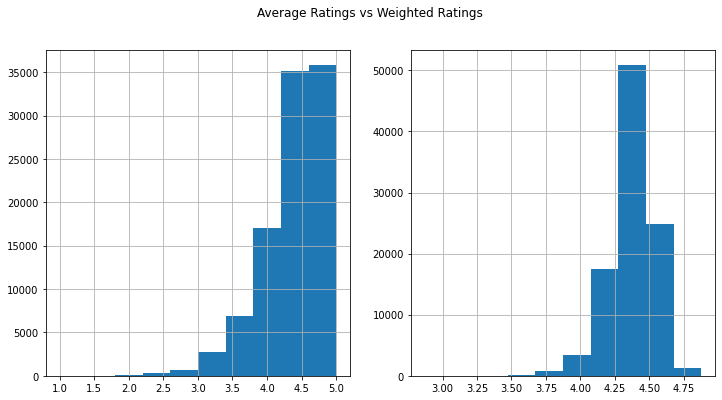

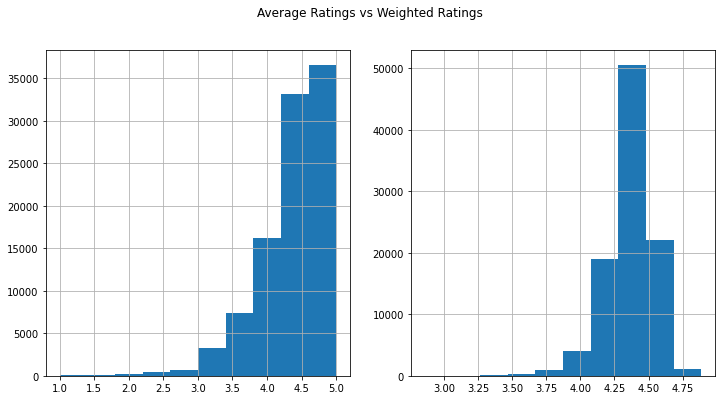

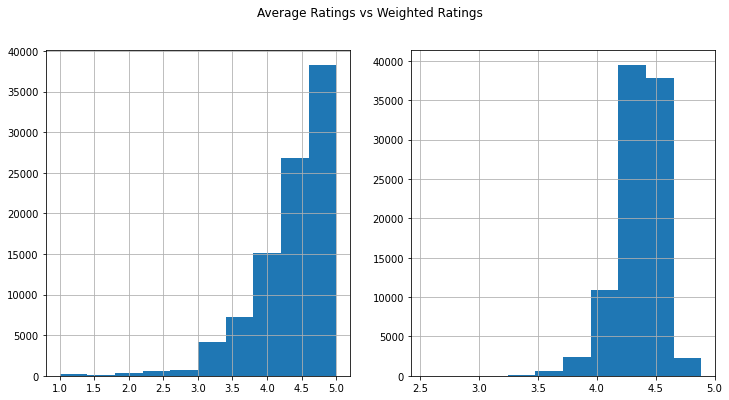

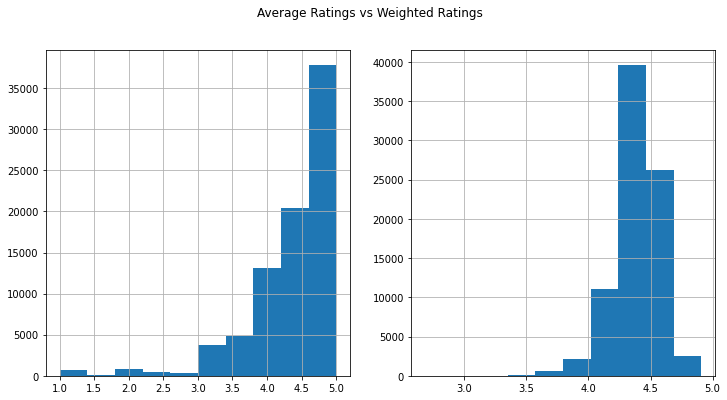

In [19]:
for rating in computed_prod_ratings:
    plot_ratings(rating)